# import

In [1]:
import pandas as pd, numpy as np, re, scipy.stats as stats
import seaborn as sns, matplotlib.pyplot as plt, plotly.express as px
from collections import Counter
from tqdm import tqdm


from sklearn import decomposition
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as PRFS
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectPercentile
from mlxtend.feature_selection import SequentialFeatureSelector


import warnings
warnings.filterwarnings('ignore')

# 1. Датасет

In [276]:
%%time
'''
Функция для предварительной обработки датасета:
1) Заполнение пустых значений в поле "Employment.Type" на "Unemployed"
2) Удаление столбцов с ID
3) Перевод столбцов в датами в формат дат
4) LabelEncoding
'''

df_pr = pd.read_csv('train_LTFS.csv')

def preprocess_df(df):
    print('Start...')
    df['Employment.Type'].fillna('Unemployed', inplace=True)
    df.drop_duplicates(inplace=True)
    df.drop(['MobileNo_Avl_Flag', 'PRI.CURRENT.BALANCE'], axis=1, inplace=True)
    
    drops = [col for ind, col in enumerate(df.columns) if re.search('id', col.lower())]
    df.drop(drops, axis=1, inplace=True)

    
    print('Find dates...')
    df['AVERAGE.ACCT.AGE'] = [int(re.findall('[0-9]+', len_hist)[0])*12 + int(re.findall('[0-9]+', len_hist)[1]) 
                              for len_hist in df['AVERAGE.ACCT.AGE']]
    
    df['CREDIT.HISTORY.LENGTH'] = [int(re.findall('[0-9]+', len_hist)[0])*12 + int(re.findall('[0-9]+', len_hist)[1]) 
                              for len_hist in df['CREDIT.HISTORY.LENGTH']]
    
    print('To datetime...')    
    df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], errors='coerce').dt.year
    df['Date.of.Birth'] = df['Date.of.Birth'] \
            .apply(lambda x: x - 100 if x >= 2005 else x)
    
    df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], errors='coerce').dt.month    

    print('Label Encoder...')
    df['Employment.Type'] = LabelEncoder().fit_transform(df['Employment.Type'])
    df['PERFORM_CNS.SCORE.DESCRIPTION'] = LabelEncoder().fit_transform(df['PERFORM_CNS.SCORE.DESCRIPTION'])
    
    df.dropna(axis=0, inplace=True)
    print('End')
    
    return df

df = preprocess_df(df_pr)
print(df.shape)
print()

Start...
Find dates...
To datetime...
Label Encoder...
End
(233154, 31)

CPU times: total: 15.5 s
Wall time: 15.5 s


In [287]:
# Удаляем выбросы с помощью Z-score
df_pr = pd.read_csv('train_LTFS.csv')

z = np.abs(stats.zscore(df))
data_clean = df[(z < 3).all(axis=1)]

print(f'размерность оригинального датасета {df_pr.shape}')
print(f'размерность после предобработки {data_clean.shape}')

data_clean.head()

размерность оригинального датасета (233154, 41)
размерность после предобработки (174993, 31)


,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,Driving_flag,Passport_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
1,47145,65550,73.23,1985,1,9,1,0,0,0,...,0,0,1991,0,0,1,23,23,0,1
3,57513,66113,88.48,1993,1,10,1,0,0,0,...,0,0,31,0,0,0,8,15,1,1
4,52378,60300,88.39,1977,1,9,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5,54513,61900,89.66,1990,1,9,1,0,0,0,...,0,0,1347,0,0,0,21,24,0,0
6,46349,61500,76.42,1988,0,9,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [288]:
%%time

'Определим переменные, которые сильнее всего влияют на loan_default и их оптимальное количество'

y = data_clean.loan_default
x = data_clean.drop('loan_default', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25)


log = Pipeline(steps=[('sc', MinMaxScaler()),
                              ('sl', SelectKBest(score_func=f_classif, k=10)),
                              ('model', LogisticRegression())])

log.fit(x_train, y_train)
                       
param_grid = {'sl__k': [2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]}     
                
search_log = GridSearchCV(log, 
                             param_grid, 
                             cv=7, 
                             n_jobs=-1, 
                             scoring='roc_auc', 
                             refit=True, 
                             verbose=10)
                
search_log.fit(x_train, y_train)

print()
print(f'Оптимальное количество параметров - {search_log.best_estimator_[1]}')
print()

Fitting 7 folds for each of 16 candidates, totalling 112 fits

Оптимальное количество параметров - SelectKBest(k=20)

CPU times: total: 2.62 s
Wall time: 28.5 s


In [289]:
# выбранные колонки
select = SelectKBest(score_func=f_classif, k=20)
best = select.fit_transform(x, y)

columns_imp=x.columns[select.get_support()].to_list()
columns_imp

['disbursed_amount',
 'asset_cost',
 'ltv',
 'Date.of.Birth',
 'Employment.Type',
 'DisbursalDate',
 'Aadhar_flag',
 'PERFORM_CNS.SCORE',
 'PERFORM_CNS.SCORE.DESCRIPTION',
 'PRI.NO.OF.ACCTS',
 'PRI.ACTIVE.ACCTS',
 'PRI.OVERDUE.ACCTS',
 'PRI.SANCTIONED.AMOUNT',
 'PRI.DISBURSED.AMOUNT',
 'PRIMARY.INSTAL.AMT',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'AVERAGE.ACCT.AGE',
 'CREDIT.HISTORY.LENGTH',
 'NO.OF_INQUIRIES']

In [290]:
# нормируем данные

for ind, val in enumerate(data_clean[columns_imp]):
    data_clean[val] = np.log1p(data_clean[val])

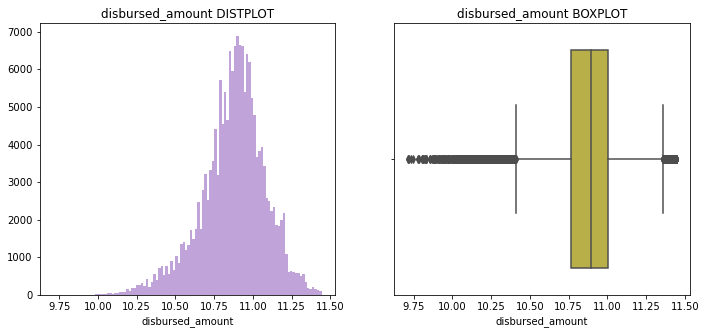

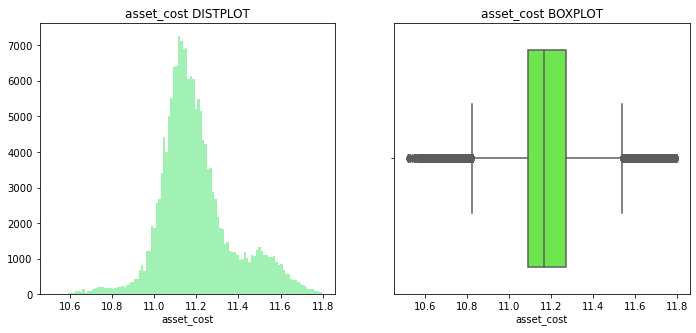

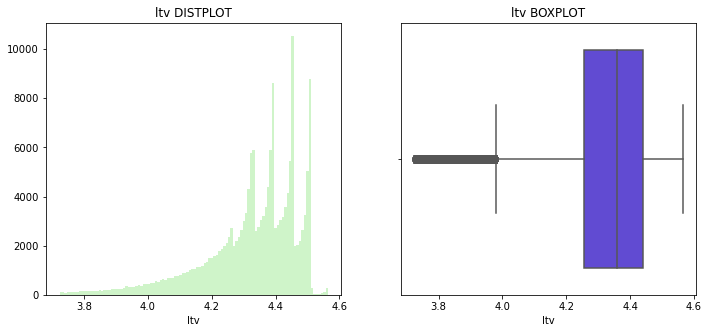

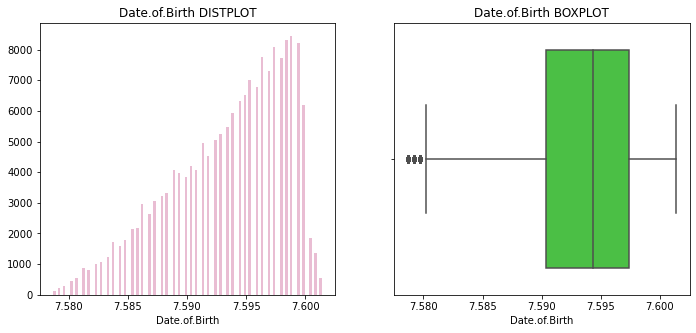

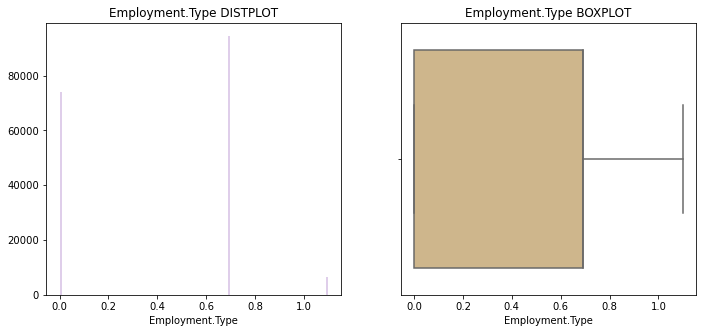

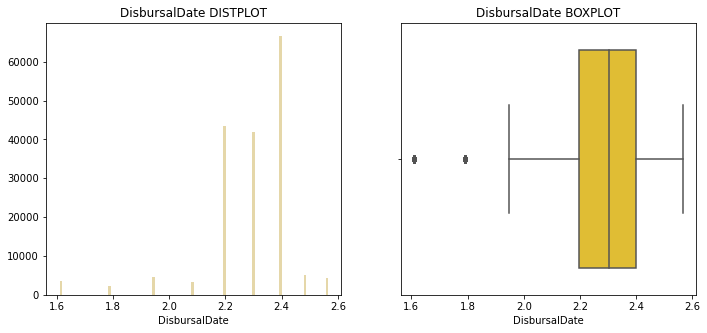

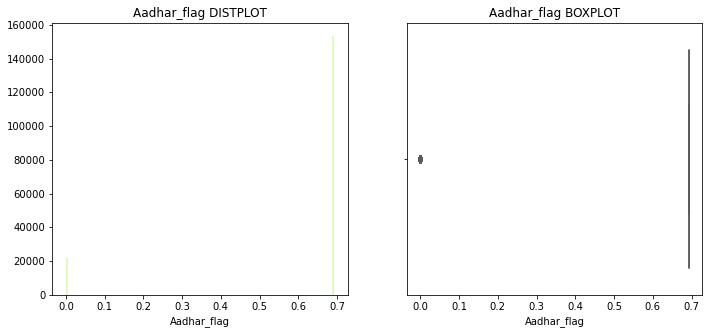

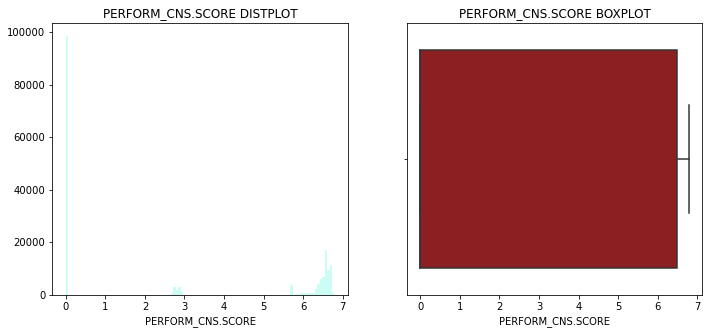

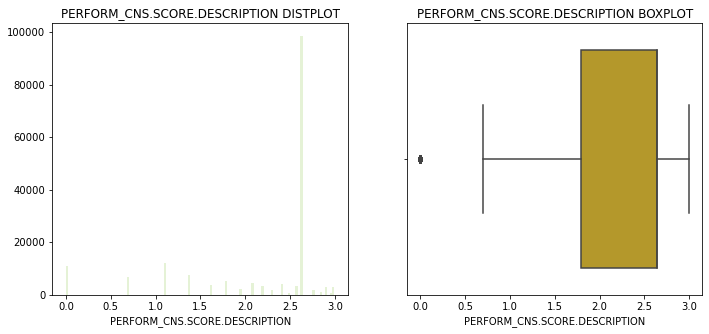

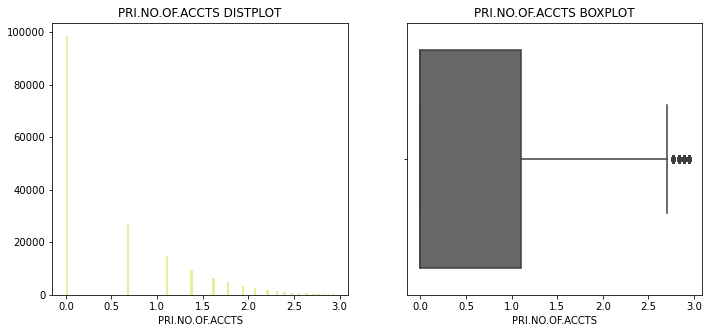

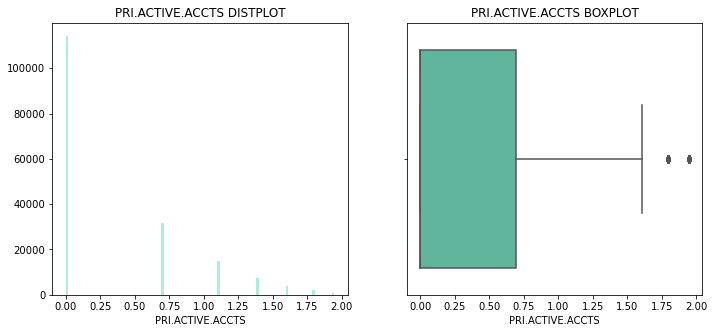

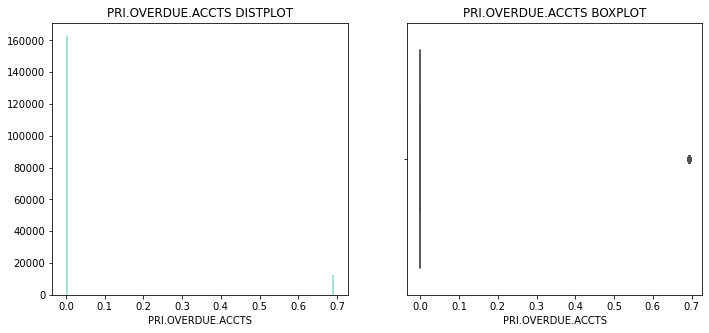

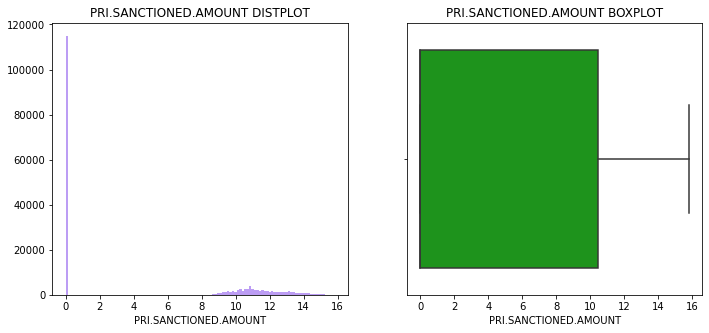

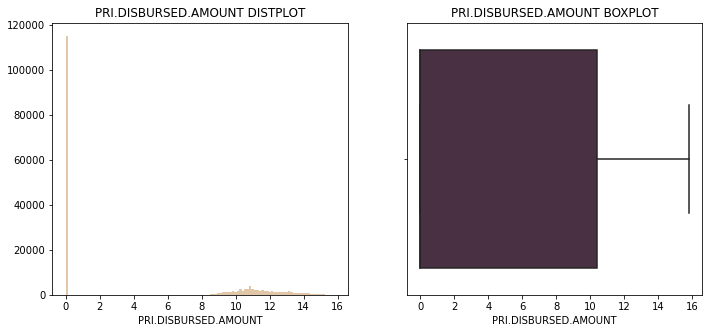

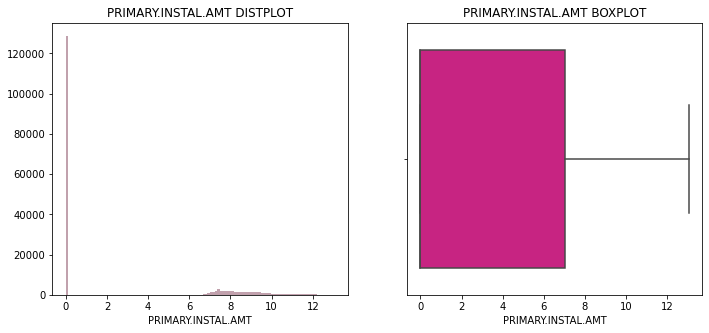

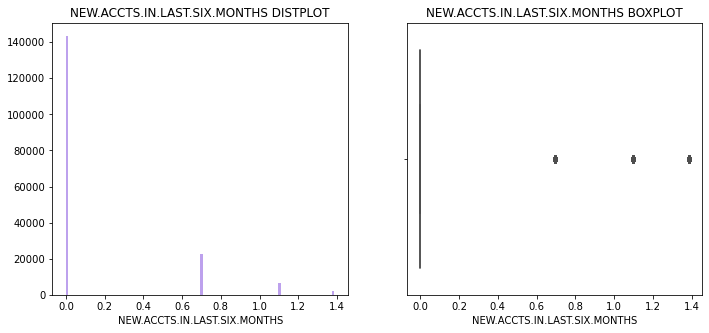

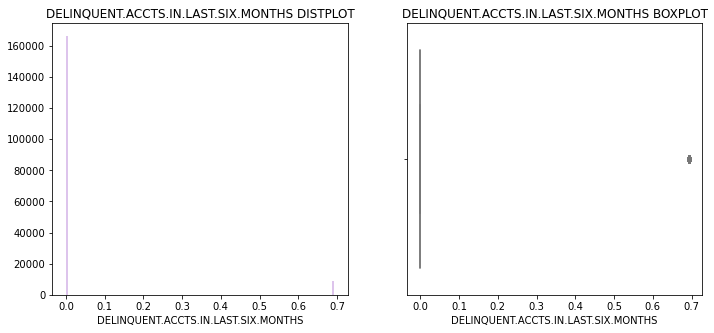

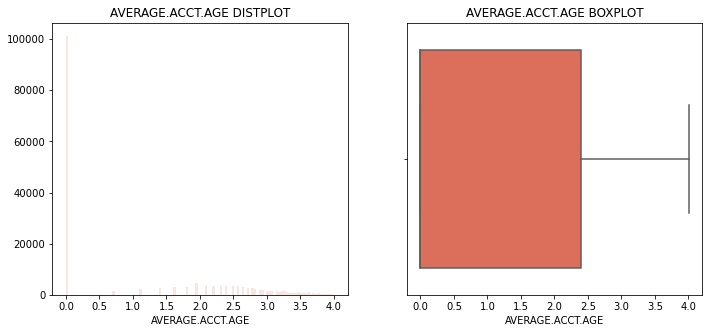

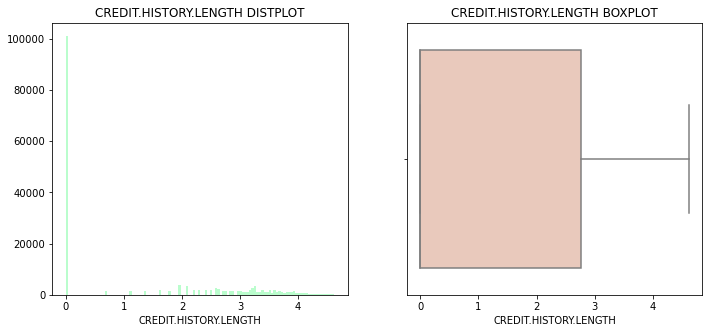

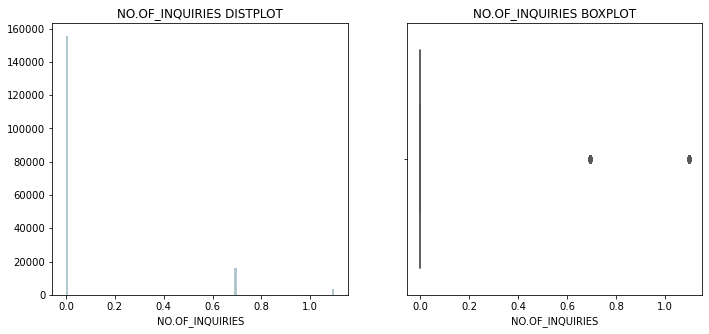

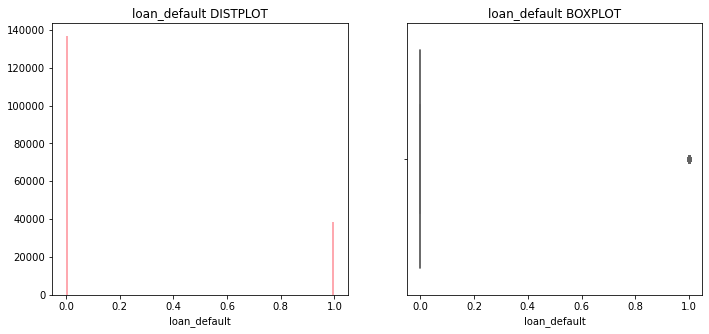

In [10]:
plt.rcParams['figure.figsize'] = (18, 5)

for col in data_clean[columns_imp+['loan_default']].columns:
    plt.subplot(1, 3, 1)
    sns.distplot((data_clean[col]), bins=110, 
                 color = (np.random.random(), np.random.random(), np.random.random()), kde=False)
    plt.title(f'{col} DISTPLOT')

    plt.subplot(1, 3, 2)
    sns.boxplot((data_clean[col]), color = (np.random.random(), np.random.random(), np.random.random()))
    plt.title(f'{col} BOXPLOT')
    plt.show()

In [39]:
'''
Также была реализация выделения важных признаков с помощью RandomForestClassifier, 
но SelectKBest показало лучшие результаты
'''

# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# forest_importances = pd.Series(importances, index=x.columns.to_list())
# colors = []
# columns_imp = []
# for ind, imp in enumerate(forest_importances):
#     if imp >=0.04:
#         colors.append('green')
#         columns_imp.append(forest_importances.index[ind])        
#     else: 
#         colors.append('blue')


# fig, ax = plt.subplots(figsize=(15, 8))
# forest_importances.plot.bar(yerr=std, ax=ax, color=colors)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# 2. AutoML

In [134]:
# !pip uninstall scikit-learn -y
# !pip uninstall numpy -y
# !pip install scikit-learn==0.23.2
# !pip install numpy==1.20
# !pip install pycaret

# import pycaret
# from pycaret.classification import *
# from pycaret.utils import enable_colab
# enable_colab()

In [135]:
# import h2o
# from h2o.automl import H2OAutoML

Воспользуемся библиотекой LightAutoML для нахождения предварительной оценки по моделям.
В данном случае, не используется библиотека PyCaret, которая была в прошлый раз, так как не показывает высокую производительность на больших датасетах

In [197]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [266]:
# Считывание датасета, небольшая очистка, удаление столбцов с id
df_auto = pd.read_csv('train_LTFS.csv')

df_auto.drop(['MobileNo_Avl_Flag', 'PRI.CURRENT.BALANCE'], axis=1, inplace=True)
ids = [col for ind, col in enumerate(df_auto.columns) if re.search('id', col.lower())]
df_auto.drop(ids, axis=1, inplace=True)
df_auto.drop_duplicates(inplace=True)
df_auto.dropna(axis=0, inplace=True)

print('df shape - {}'.format(df_auto.shape))


xx = df_auto.drop('loan_default', axis=1)
yy = df_auto.loan_default

x_train, x_test, y_train, y_test = train_test_split(xx, yy,
                                                    stratify=yy, test_size=0.25)

x_train['loan_default'] = y_train
x_train.shape, y_train.shape, x_test.shape, y_test.shape

df shape - (225491, 31)


((169118, 31), (169118,), (56373, 30), (56373,))

In [267]:
x_train.head(2)

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,Driving_flag,Passport_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
170317,65569,83163,84.17,14-07-91,Salaried,13-10-18,1,0,0,0,...,0,0,12269,0,3,0,1yrs 0mon,2yrs 11mon,3,1
131541,71123,109098,66.91,01-01-97,Salaried,29-09-18,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [268]:
roles = {
    'target': 'loan_default',
}

automl = TabularAutoML(
    task=Task('binary'),
    timeout=60*3,
    reader_params={'n_jobs': 6, 'cv': 5, 'random_state': 101}
)

rd = ReportDeco('TabReport2')
automl_rd = rd(automl)

models = automl_rd.fit_predict(x_train, roles=roles, verbose=1)

[19:23:15] Stdout logging level is INFO.
[19:23:15] Task: binary

[19:23:15] Start automl preset with listed constraints:
[19:23:15] - time: 300.00 seconds
[19:23:15] - CPU: 4 cores
[19:23:15] - memory: 16 GB

[19:23:15] Train data shape: (169118, 31)

[19:23:45] Layer 1 train process start. Time left 269.75 secs
[19:23:51] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:24:05] Time limit exceeded after calculating fold 3

[19:24:05] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.6354292131323951
[19:24:05] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:24:05] Time left 250.11 secs

[19:24:08] Selector_LightGBM fitting and predicting completed
[19:24:15] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:24:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.6461388644488824
[19:24:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:24:34] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.0

In [ ]:
Lvl_0_Pipe_1_Mod_0_LightGBM
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
Lvl_0_Pipe_1_Mod_2_CatBoost
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

<AxesSubplot:xlabel='Feature'>

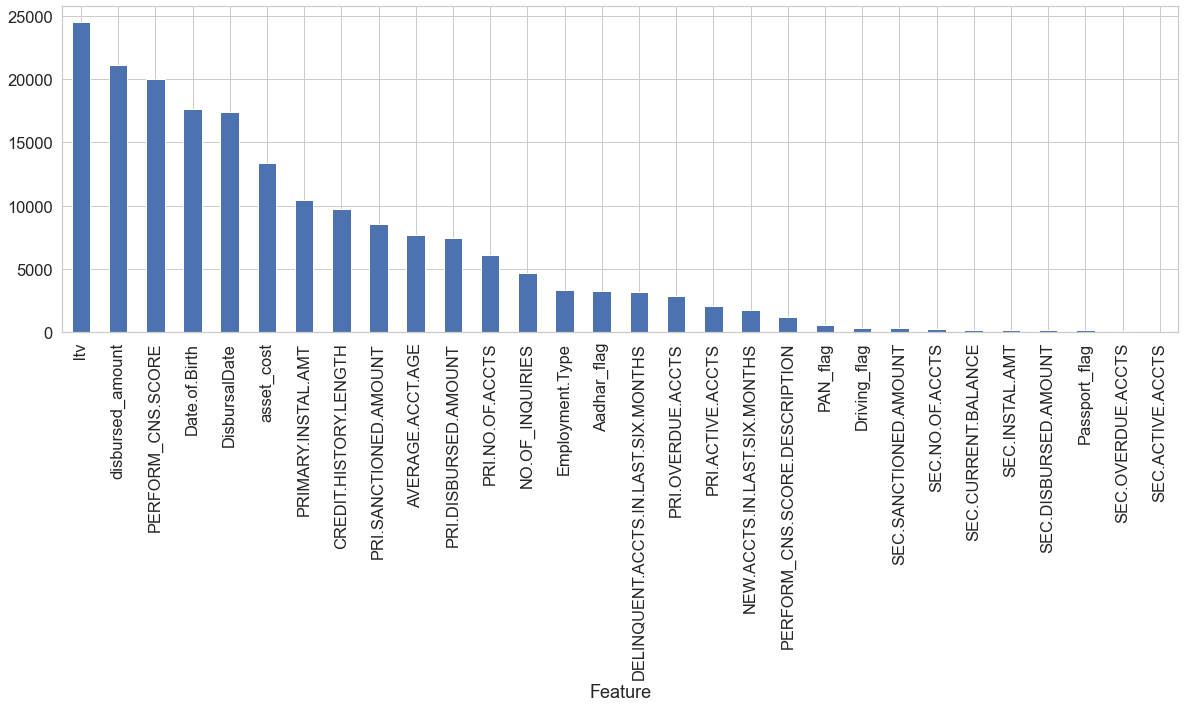

In [269]:
imps = automl_rd.model.get_feature_scores('fast')
imps.set_index('Feature')['Importance'].plot.bar(figsize=(20, 6))

In [270]:
imps.head(10)

,Feature,Importance
0,ltv,24514.055717
1,disbursed_amount,21066.907694
2,PERFORM_CNS.SCORE,20027.043957
3,Date.of.Birth,17636.558281
4,DisbursalDate,17380.054537
5,asset_cost,13405.197592
6,PRIMARY.INSTAL.AMT,10461.719209
7,CREDIT.HISTORY.LENGTH,9730.959504
8,PRI.SANCTIONED.AMOUNT,8524.043059
9,AVERAGE.ACCT.AGE,7671.993707


In [275]:
preds = automl.predict(x_test)

print(f'AUC score on train: {roc_auc_score(y_train.values, models.data[:, 0])}')
print(f'GINI score on train: {roc_auc_score(y_train.values, models.data[:, 0])*2-1}')
print()
print(f'AUC score on test: {roc_auc_score(y_test.values, preds.data[:, 0])}')
print(f'GINI score on test: {roc_auc_score(y_test.values, preds.data[:, 0])*2-1}')

AUC score on train: 0.6493588664101343
GINI score on train: 0.2987177328202686

AUC score on test: 0.6503250553387429
GINI score on test: 0.3006501106774857


# 3. Модели

In [291]:
# функция для оценки моделей
def get_report(pipe, x_test, y_test, pipe_grid=None, grid=False):
    
    predictions = pipe.predict(x_test)
    predictions = np.round(predictions.ravel(), 0)

    roc_auc_scores_pipe = roc_auc_score(y_test, pipe.predict_proba(x_test)[:, 1])
    gini = (2 * roc_auc_scores_pipe) - 1
    
    print('y_test - ', Counter(y_test))
    print('predictions - ', Counter(predictions))
    print()
    print(f'roc_auc_score - {round(roc_auc_scores_pipe, 4)}')
    print('Gini - ', round(gini, 4))
    
    if grid:
        roc_auc_scores_grid = roc_auc_score(y_test, pipe_grid.predict_proba(x_test)[:, 1])
        print(f'grid - pipe: {round(roc_auc_scores_grid - roc_auc_scores_pipe, 5)}')
        gini2 = (2 * roc_auc_scores_grid) - 1 - gini
        print('Gini with grid - ', round(gini2, 4))

    print()
    print((classification_report(y_test, predictions)))

In [292]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks

In [293]:
%%time

data_clean=data_clean[columns_imp+['loan_default']]

y = data_clean.loan_default
x = data_clean.drop('loan_default', axis=1)

imbalance = SMOTETomek(sampling_strategy='minority', n_jobs=6)
x_imb, y_imb = imbalance.fit_resample(x, y)

x_imb.shape, y_imb.shape

CPU times: total: 6min 4s
Wall time: 1min 33s


((259988, 20), (259988,))

In [294]:
x_train, x_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, test_size=0.25)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((194991, 20), (194991,), (64997, 20), (64997,))

## LogisticRegression

In [15]:
pipe_logreg = Pipeline(steps=[('sc', MinMaxScaler()), 
                       ('model', LogisticRegression(max_iter=1000, C=120, solver='lbfgs', tol=0.5))])

pipe_logreg.fit(x_train, y_train)

get_report(pipe=pipe_logreg, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({0: 32534, 1: 32534})
predictions -  Counter({1: 36514, 0: 28554})

roc_auc_score - 0.625
Gini -  0.2501

              precision    recall  f1-score   support

           0       0.61      0.53      0.57     32534
           1       0.58      0.65      0.62     32534

    accuracy                           0.59     65068
   macro avg       0.59      0.59      0.59     65068
weighted avg       0.59      0.59      0.59     65068




In [107]:
cv_pipe_logreg = cross_val_predict(pipe_logreg,
                                   cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
                                   X=x_train,
                                   y=y_train,
                                   verbose=1,
                                   n_jobs=-1,
                                   method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    2.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    3.1s finished


In [108]:
print(f'auc score = {roc_auc_score(y_train, cv_pipe_logreg[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_pipe_logreg[:, 1])) - 1 :.5f}')

auc score = 0.62571
Gini      = 0.25143


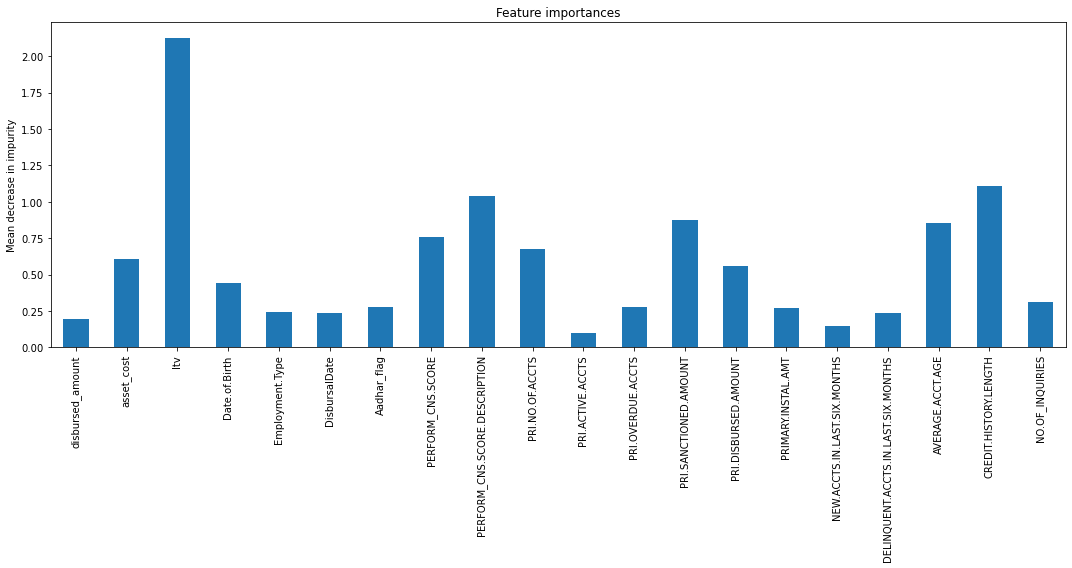

In [176]:
log_importances = pd.Series(abs(pipe_logreg[-1].coef_[0]), index=x_train.columns)

fig, ax = plt.subplots(figsize=(15,8))
log_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [172]:
pd.DataFrame(zip(pipe_logreg[-1].coef_[0], x.columns), columns=['importance', 'features']) \
                                                    .set_index('features') \
                                                    .sort_values(by='importance', ascending=False)

,importance
features,
ltv,2.125714
PERFORM_CNS.SCORE.DESCRIPTION,1.041323
AVERAGE.ACCT.AGE,0.857582
PERFORM_CNS.SCORE,0.757335
asset_cost,0.607751
PRI.DISBURSED.AMOUNT,0.557806
Date.of.Birth,0.443085
NO.OF_INQUIRIES,0.313840
PRI.OVERDUE.ACCTS,0.280278


## LinearRegression

In [168]:
pipe_linreg = Pipeline(steps=[('scaler', MinMaxScaler()), 
                       ('logistic', LinearRegression(positive=True, fit_intercept=True))])

pipe_linreg.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LinearRegression(positive=True))])

In [169]:
predictions = pipe_linreg.predict(x_test)
diff = predictions - y_test

print('MSE:', np.mean(diff**2))
print('MAE:', np.mean(abs(diff)))
print('RMSE:', np.sqrt(np.mean(diff**2)))
print()
print(classification_report(y_test, np.round(predictions.ravel(), 0)))

MSE: 0.23954659093406908
MAE: 0.47926790806564257
RMSE: 0.48943497109837697

              precision    recall  f1-score   support

           0       0.60      0.52      0.55     32516
           1       0.57      0.65      0.61     32515

    accuracy                           0.58     65031
   macro avg       0.59      0.58      0.58     65031
weighted avg       0.59      0.58      0.58     65031



In [173]:
pd.DataFrame(zip(pipe_linreg[-1].coef_, x.columns), columns=['importance', 'features']) \
                                                    .set_index('features') \
                                                    .sort_values(by='importance', ascending=False)

,importance
features,
ltv,0.508396
asset_cost,0.182113
PERFORM_CNS.SCORE.DESCRIPTION,0.163587
Date.of.Birth,0.120533
PRI.OVERDUE.ACCTS,0.067084
Employment.Type,0.061530
DisbursalDate,0.055344
NO.OF_INQUIRIES,0.051976
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,0.045509


## RandomForestClassifier

In [303]:
pipe_rforest = Pipeline(steps=[('sc', MinMaxScaler()), 
                               ('m', RandomForestClassifier(verbose=1, n_jobs=-1))])

pipe_rforest.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished


Pipeline(steps=[('sc', MinMaxScaler()),
                ('m', RandomForestClassifier(n_jobs=-1, verbose=1))])

In [178]:
get_report(pipe=pipe_rforest, x_test=x_test, y_test=y_test)
print()

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


y_test -  Counter({0: 32516, 1: 32515})
predictions -  Counter({0: 34142, 1: 30889})

roc_auc_score - 0.9085
Gini -  0.8171

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     32516
           1       0.85      0.81      0.83     32515

    accuracy                           0.83     65031
   macro avg       0.83      0.83      0.83     65031
weighted avg       0.83      0.83      0.83     65031




[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished


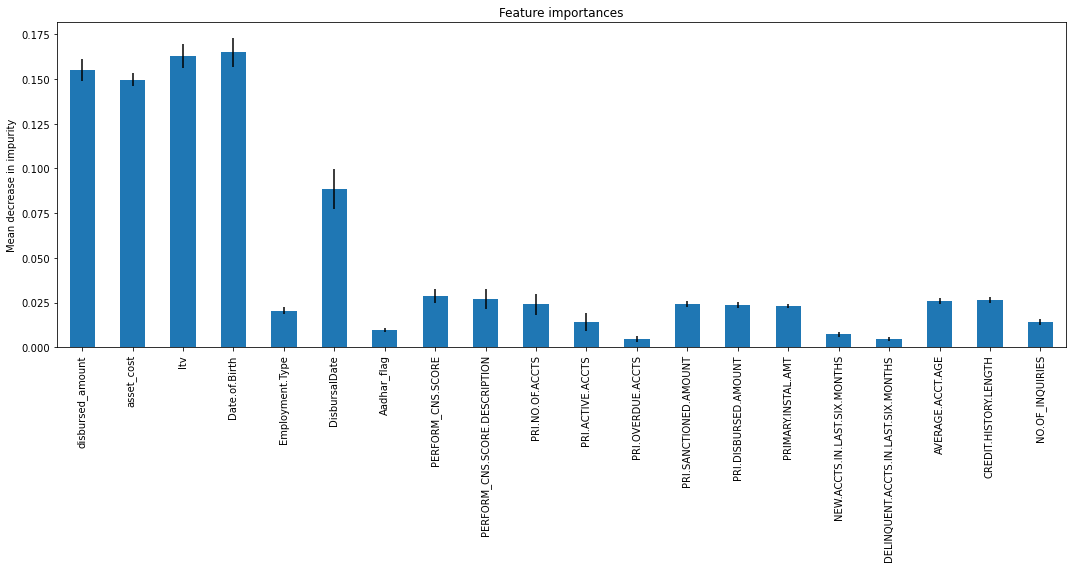

In [182]:
importances = pipe_rforest[-1].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe_rforest[-1].estimators_], axis=0)

forest_importances = pd.Series(importances, index=x_train.columns)

fig, ax = plt.subplots(figsize=(15,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [180]:
%%time
cv_pipe_rforest = cross_val_predict(pipe_rforest,
                                    cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
                                    X=x_train,
                                    y=y_train,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:  1.1min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:  1.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:  1.1min remaining:   47.8s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:  1.1min remaining:   25.5s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  1.2min finished


CPU times: total: 156 ms
Wall time: 1min 15s


In [181]:
print(f'auc score = {roc_auc_score(y_train, cv_pipe_rforest[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_pipe_rforest[:, 1]) - 1) :.5f}')

auc score = 0.89945
Gini      = 0.79891


## LGBMClassifier

In [319]:
pipe_lgbm_cls = Pipeline(steps=[('sc', MinMaxScaler()), 
                                ('model', LGBMClassifier(boosting_type='gbdt',
                                                         objective='binary' ,
                                                         n_estimators=1000,
                                                         max_depth=-1,
                                                         learning_rate=0.95,
                                                         num_leaves=70,
                                                         importance_type='gain'))])

pipe_lgbm_cls.fit(x_train, y_train)

Pipeline(steps=[('sc', MinMaxScaler()),
                ('model',
                 LGBMClassifier(importance_type='gain', learning_rate=0.95,
                                n_estimators=1000, num_leaves=70,
                                objective='binary'))])

In [320]:
get_report(pipe=pipe_lgbm_cls, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({1: 32499, 0: 32498})
predictions -  Counter({0: 34782, 1: 30215})

roc_auc_score - 0.882
Gini -  0.7641

              precision    recall  f1-score   support

           0       0.80      0.85      0.82     32498
           1       0.84      0.78      0.81     32499

    accuracy                           0.82     64997
   macro avg       0.82      0.82      0.82     64997
weighted avg       0.82      0.82      0.82     64997




In [17]:
get_report(pipe=pipe_lgbm_cls, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({0: 32534, 1: 32534})
predictions -  Counter({0: 34847, 1: 30221})

roc_auc_score - 0.8822
Gini -  0.7645

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     32534
           1       0.84      0.78      0.81     32534

    accuracy                           0.82     65068
   macro avg       0.82      0.82      0.82     65068
weighted avg       0.82      0.82      0.82     65068




In [82]:
pd.DataFrame(data=MinMaxScaler().fit_transform(pipe_lgbm_cls[-1].feature_importances_.reshape(-1, 1)), 
             index=x_imb.columns) \
             .sort_values(by=0, ascending=False)

,0
Date.of.Birth,1.000000
ltv,0.245004
disbursed_amount,0.191220
asset_cost,0.187490
DisbursalDate,0.000000


In [185]:
%%time
cv_lgbm_cls = cross_val_predict(pipe_lgbm_cls,
                                    cv=StratifiedKFold(n_splits=10, shuffle=True),
                                    X=x_train,
                                    y=y_train,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   19.3s remaining:   45.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   19.7s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   33.6s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.8s finished


CPU times: total: 109 ms
Wall time: 34.1 s


In [187]:
print(f'auc score = {roc_auc_score(y_train, cv_lgbm_cls[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_lgbm_cls[:, 1]) - 1) :.5f}')

auc score = 0.88151
Gini      = 0.76302


## XGBClassifier

In [188]:
pipe_xgb_cls = Pipeline(steps=[('scaler', MinMaxScaler()), 
                               ('model', XGBClassifier())])

pipe_xgb_cls.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [189]:
get_report(pipe=pipe_xgb_cls, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({0: 32516, 1: 32515})
predictions -  Counter({0: 41730, 1: 23301})

roc_auc_score - 0.8932
Gini -  0.7864

              precision    recall  f1-score   support

           0       0.77      0.99      0.87     32516
           1       0.99      0.71      0.82     32515

    accuracy                           0.85     65031
   macro avg       0.88      0.85      0.85     65031
weighted avg       0.88      0.85      0.85     65031




In [190]:
pd.DataFrame(data=MinMaxScaler().fit_transform(pipe_xgb_cls[-1].feature_importances_.reshape(-1, 1)), 
             index=x_imb.columns) \
             .sort_values(by=0, ascending=False)

,0
Date.of.Birth,1.000000
DisbursalDate,0.935694
PERFORM_CNS.SCORE.DESCRIPTION,0.354145
Employment.Type,0.295605
Aadhar_flag,0.271723
PRI.NO.OF.ACCTS,0.232952
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,0.218745
PRI.ACTIVE.ACCTS,0.213059
NO.OF_INQUIRIES,0.165058
PRI.OVERDUE.ACCTS,0.135843


In [191]:
%%time
cv_xgb_cls = cross_val_predict(pipe_xgb_cls,
                                    cv=StratifiedKFold(n_splits=7, shuffle=True),
                                    X=x_train,
                                    y=y_train,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:   29.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:   29.1s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   29.1s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:   29.1s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   51.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   51.9s finished


CPU times: total: 93.8 ms
Wall time: 52.4 s


In [192]:
print(f'auc score = {roc_auc_score(y_train, cv_xgb_cls[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_xgb_cls[:, 1]) - 1) :.5f}')

auc score = 0.89322
Gini      = 0.78644


## CatBoost

In [324]:
from catboost import CatBoostClassifier, cv, Pool, MetricVisualizer
from catboost.utils import select_threshold, get_roc_curve, get_fpr_curve, get_fnr_curve
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures

In [325]:
x_train_cat = MinMaxScaler().fit_transform(x_train)
x_test_cat = MinMaxScaler().fit_transform(x_test)

In [326]:
model_catboost_cls = CatBoostClassifier(
    loss_function='Logloss', custom_loss='AUC', #eval_metric='AUC',
    learning_rate=0.01, iterations=5000,
#     l2_leaf_reg=7, random_strength=10, bagging_temperature=7
    l2_leaf_reg=10, random_strength=101, bagging_temperature=5, depth=8,
)

m = model_catboost_cls.fit(x_train_cat, y_train, eval_set=(x_test_cat, y_test),
                       verbose=500, plot=True, early_stopping_rounds=200)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6929962	test: 0.6929941	best: 0.6929941 (0)	total: 36.4ms	remaining: 4m 33s
500:	learn: 0.6328024	test: 0.6356906	best: 0.6356906 (500)	total: 14.4s	remaining: 3m 21s
1000:	learn: 0.6089126	test: 0.6136735	best: 0.6136735 (1000)	total: 29.3s	remaining: 3m 10s
1500:	learn: 0.5655187	test: 0.5714019	best: 0.5714019 (1500)	total: 44s	remaining: 2m 55s
2000:	learn: 0.3950272	test: 0.3998272	best: 0.3998272 (2000)	total: 59s	remaining: 2m 42s
2500:	learn: 0.3544193	test: 0.3602240	best: 0.3602240 (2500)	total: 1m 14s	remaining: 2m 28s
3000:	learn: 0.3429293	test: 0.3509107	best: 0.3509107 (3000)	total: 1m 30s	remaining: 2m 15s
3500:	learn: 0.3364205	test: 0.3466983	best: 0.3466983 (3500)	total: 1m 48s	remaining: 2m 3s
4000:	learn: 0.3314318	test: 0.3439918	best: 0.3439908 (3998)	total: 2m 6s	remaining: 1m 50s
4500:	learn: 0.3280757	test: 0.3433612	best: 0.3433612 (4500)	total: 2m 24s	remaining: 1m 36s
5000:	learn: 0.3249681	test: 0.3429514	best: 0.3429512 (4999)	total: 2m 41s	re

In [234]:
print(f'auc score = {roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]) - 1) :.5f}')

auc score = 0.89697
Gini      = 0.79394


# Результаты

In [300]:
da = [['LogisticRegression',
       roc_auc_score(y_test, pipe_logreg.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, pipe_logreg.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(pipe_logreg.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_logreg.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_logreg.predict(x_test), 0), average='weighted')[2]],
      
      ['LinearRegression',
       0,
       0,
       precision_recall_fscore_support(y_test, np.round(pipe_linreg.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_linreg.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_linreg.predict(x_test), 0), average='weighted')[2]],
      
      ['RandomForestClassifier',
       roc_auc_score(y_test, search_rforest.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, search_rforest.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(search_rforest.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(search_rforest.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(search_rforest.predict(x_test), 0), average='weighted')[2]],
      
      ['LGBMClassifier',
       roc_auc_score(y_test, search_lgbm_cls.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, search_lgbm_cls.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(search_lgbm_cls.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(search_lgbm_cls.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(search_lgbm_cls.predict(x_test), 0), average='weighted')[2]],
      
      ['XGBClassifier',
       roc_auc_score(y_test, search_xgb_cls.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, search_xgb_cls.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(search_xgb_cls.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(search_xgb_cls.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(search_xgb_cls.predict(x_test), 0), average='weighted')[2]],
 
      ['CatBoostClassifier',
       roc_auc_score(y_val, model_catboost_cls.predict_proba(x_val_cat)[:, 1]),
       2 * roc_auc_score(y_val, model_catboost_cls.predict_proba(x_val_cat)[:, 1])-1,
       precision_recall_fscore_support(y_val, np.round(model_catboost_cls.predict(x_val_cat), 0), average='weighted')[0],
       precision_recall_fscore_support(y_val, np.round(model_catboost_cls.predict(x_val_cat), 0), average='weighted')[1],
       precision_recall_fscore_support(y_val, np.round(model_catboost_cls.predict(x_val_cat), 0), average='weighted')[2]],

      ['NN',
       0.7557132080694833,
       2 * 0.7557132080694833 - 1,
       0.78,
       0.80,
       0.77,]
      
     ]

In [301]:
result = pd.DataFrame(da, columns=['Model', 'AUC', 'GINI', 'PRECISION', 'RECALL', 'FSCORE']).set_index('Model')

result.sort_values(by='AUC', ascending=False)

,AUC,GINI,PRECISION,RECALL,FSCORE
Model,,,,,
RandomForestClassifier,0.899454,0.798908,0,0,0
CatBoost,0.896971,0.793941,0,0,0
XGBClassifier,0.893220,0.786440,0,0,0
LGBMClassifier,0.881511,0.763022,0,0,0
LogisticRegression,0.625714,0.251429,"[0.6056857996096597, 0.5816952479620491]","[0.5281254805474397, 0.6561827240481414]","[0.5642528162804835, 0.6166978991535915]"
NN,0.000000,0.000000,0,0,0


In [271]:
from sklearn.metrics import precision_recall_fscore_support

In [284]:
precision_recall_fscore_support(y_test, np.round(model_catboost_cls.predict_proba(x_test_cat)[:, 1]), average='binary')[:-1]

(0.990428342500758, 0.7033061663847455, 0.8225307531832242)